In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/prac/task2
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from optimization import GDClassifier, SGDClassifier
import numpy as np
import seaborn as sns
from utils import grad_finite_diff
import matplotlib.pyplot as plt
from oracles import BinaryLogistic
from nltk import WordNetLemmatizer
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
%load_ext autoreload
from tqdm import tqdm
%autoreload 2
sns.set(style="darkgrid")

/content/drive/MyDrive/Colab Notebooks/prac/task2


In [ ]:
data_train = pd.read_csv('toxic_train.csv')
data_test = pd.read_csv('toxic_test.csv')

In [ ]:
data_train['comment_text'] = data_train['comment_text'].str.lower()
data_train['comment_text'] = data_train['comment_text'].str.replace('[^A-Za-z0-9]', ' ', regex=True)
data_test['comment_text'] = data_test['comment_text'].str.lower()
data_test['comment_text'] = data_test['comment_text'].str.replace('[^A-Za-z0-9]', ' ', regex=True)

In [ ]:
data_train.head()

,Unnamed: 0,comment_text,is_toxic
0,0,explanation why the edits made under my userna...,False
1,1,d aww he matches this background colour i m s...,False
2,2,hey man i m really not trying to edit war it...,False
3,3,more i can t make any real suggestions on im...,False
4,4,you sir are my hero any chance you remember...,False


In [ ]:
rng = np.random.default_rng(132)
data_size = len(data_train['comment_text'])
idx_ = rng.choice(data_size, data_size, replace=False)
valid_size = 10000
train_size = data_size - valid_size
print(idx_)

[14221 44557 14748 ...  8333  7423 44542]


In [ ]:
vectoriser = CountVectorizer(min_df=0.0001)
X_train = vectoriser.fit_transform(data_train['comment_text'])[idx_[:train_size]]
y_train = 2 * np.array(data_train['is_toxic'][idx_[:train_size]]) - 1
X_val = vectoriser.fit_transform(data_train['comment_text'])[idx_[train_size:]]
y_val = 2 * np.array(data_train['is_toxic'][idx_[train_size:]]) - 1
vectoriser.fit(data_train['comment_text'])
X_test = vectoriser.transform(data_test['comment_text'])
y_test = 2 * np.array(data_test['is_toxic']) - 1

In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)
print(X_test.shape)

X_train (42061, 16050)
y_train (42061,)
X_val (10000, 16050)
y_val (10000,)
(20676, 16050)


### Experiment 0

In [ ]:
from numpy.lib.function_base import kaiser
rng = np.random.default_rng(512)
m = rng.integers(3, 7)
n = rng.integers(3, 7)
A = rng.uniform(-100, 100, size=(m, n))
y = rng.choice([-1, 1], size=m)
def fix(A, y, func):
    def f(w):
        return func(A, y, w)
    return f

loss_func = fix(A, y, BinaryLogistic(0).func)
grad = BinaryLogistic(0).grad
k = 10
history_methods = dict()
history_methods['ther'] = []
history_methods['numer'] = []
for i in range(k):
    w = rng.uniform(-5, 5, size=n)
    ther = grad(A, y, w)
    numer = grad_finite_diff(loss_func, w)
    history_methods['ther'].append(ther)
    history_methods['numer'].append(numer)
    print(f"theoretical method - {np.around(ther, 8)} | "
          f"numerical method - {np.around(numer, 8)}")
mean_err = 0
for i in range(k):
    mean_err += np.mean(np.abs(history_methods['ther'][i] - 
                               history_methods['numer'][i]))
mean_err /= k
print(mean_err)

theoretical method - [  3.53520965  23.531242   -17.0139632 ] | numerical method - [  3.53520733  23.53124131 -17.01396428]
theoretical method - [  3.53520965  23.531242   -17.0139632 ] | numerical method - [  3.53521017  23.53124273 -17.01396286]
theoretical method - [ 37.34401026 -30.30346696 -30.86052417] | numerical method - [ 37.34401162 -30.30346534 -30.86052516]
theoretical method - [ 37.73437156 -11.03178972 -32.61996966] | numerical method - [ 37.73437243 -11.03178917 -32.61996966]
theoretical method - [  3.53520965  23.531242   -17.0139632 ] | numerical method - [  3.53520875  23.53124273 -17.01396286]
theoretical method - [ -0.3903613  -19.27167724   1.75944549] | numerical method - [ -0.39036152 -19.27167688   1.75944592]
theoretical method - [  4.60200334  22.43801483 -17.64465059] | numerical method - [  4.60200624  22.43801589 -17.64465054]
theoretical method - [ 37.73437156 -11.03178972 -32.61996966] | numerical method - [ 37.73437243 -11.03178988 -32.61997108]
theoreti

###  Experiment 1.  
Проверим как влияет на наш алгоритм $\alpha$ при фиксированных $β=1$ и начальном приближении $ω_{0}=θ$, гдe $θ = (0,\ldots,0) \in ℝ^D$ ;   
$D$ - размер признакового пространства

In [ ]:
alphas = np.logspace(-4 , -1, 8)
beta = 0
w_0 = np.zeros(X_train.shape[1])
history_GD = []
max = 0
best_alpha = alphas[0]
for i in tqdm(range(len(alphas))):
    classifier_GD = GDClassifier(
        loss_function='binary_logistic',
        step_alpha=alphas[i],
        step_beta=beta,
        l2_coef=0.1,
        X_val=X_val,
        y_val=y_val)
    history_GD.append(classifier_GD.fit(X_train, 
                                        y_train, 
                                        w_0=np.zeros(X_train.shape[1]), 
                                        trace=True))
    acc = np.mean(classifier_GD.predict(X_val) == y_val)
    if acc > max:
        max = acc
        best_alpha = alphas[i]
print()
print('accuracy on validation', max)
print('best_alpha', best_alpha)


100%|██████████| 8/8 [01:12<00:00,  9.12s/it]


accuracy on validation 0.8063
best_alpha 0.1


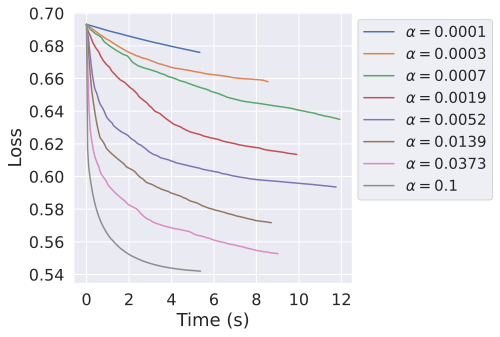

In [ ]:
plt.figure(figsize=(5,5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\alpha=' + str(round(alpha, 4)) + '$' for alpha in alphas]
for history in history_GD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['func'],
                     ci=False, label=False)
plt.legend(labels,
           bbox_to_anchor=(1.53, 1),
           fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./experiment1/alpha/gd_loss_time.pdf',
            bbox_inches='tight')


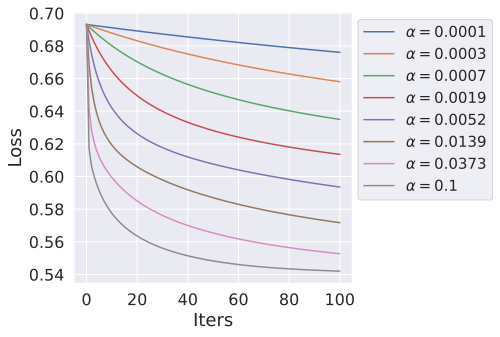

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Iters', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\alpha=' + str(round(alpha, 4)) + '$' for alpha in alphas]
for history in history_GD:
    g = sns.lineplot(palette='muted', x=range(len(history['func'])),
                     y=history['func'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./experiment1/alpha/gd_loss__iters.pdf',
            bbox_inches='tight')

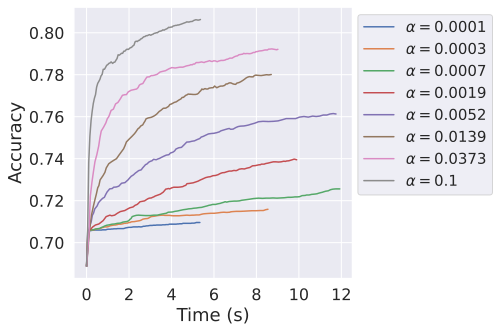

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\alpha=' + str(round(alpha, 4)) + '$' for alpha in alphas]
for history in history_GD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['acc'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./experiment1/alpha/gd_acc_time.pdf',
            bbox_inches='tight')


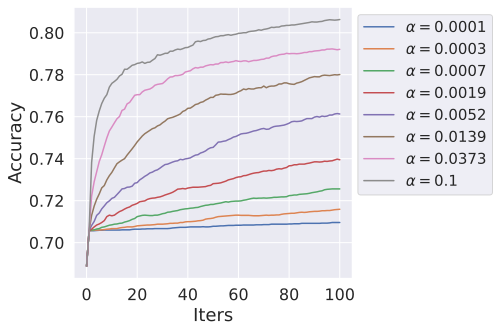

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Iters', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\alpha=' + str(round(alpha, 4)) + '$' for alpha in alphas]
for history in history_GD:
    g = sns.lineplot(palette='muted', 
                     x=range(len(history['acc'])),
                     y=history['acc'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./experiment1/alpha/gd_acc_iters.pdf',
            bbox_inches='tight')

In [ ]:
alphas = np.logspace(0 , 1, 5)
beta = 0
w_0 = np.zeros(X_train.shape[1])
history_GD = []
for i in tqdm(range(len(alphas))):
    classifier_GD = GDClassifier(
        loss_function='binary_logistic',
        step_alpha=alphas[i],
        step_beta=beta,
        l2_coef=0.1,
        X_val=X_val,
        y_val=y_val)
    history_GD.append(classifier_GD.fit(X_train, 
                                        y_train, 
                                        w_0=np.zeros(X_train.shape[1]), 
                                        trace=True))

100%|██████████| 5/5 [00:28<00:00,  5.71s/it]


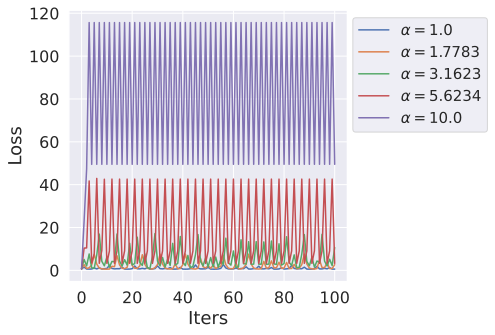

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Iters', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\alpha=' + str(round(alpha, 4)) + '$' for alpha in alphas]
for history in history_GD:
    g = sns.lineplot(palette='muted', x=range(len(history['func'])),
                     y=history['func'],
                     ci=False, label=False)
plt.legend(labels,
           bbox_to_anchor=(1.53, 1),
           fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./experiment1/alpha/gd_loss__iters_big_alphas.pdf',
            bbox_inches='tight')

In [ ]:
betas = np.logspace(-2, 0.7, 6)
alpha = best_alpha
history_GD = []
max = 0 
best_beta = betas[0]
for i in tqdm(range(len(betas))):
    classifier_GD = GDClassifier(
        loss_function='binary_logistic',
        step_alpha=alpha,
        step_beta=betas[i],
        l2_coef=0.1,
        X_val=X_val,
        y_val=y_val)
    history_GD.append(classifier_GD.fit(X_train, 
                                        y_train, 
                                        w_0=np.zeros(X_train.shape[1]), 
                                        trace=True))
    acc = np.mean(classifier_GD.predict(X_val) == y_val)
    if acc > max:
        max = acc
        best_beta = betas[i]
print()
print("best acc on validation", max)
print("best beta", best_beta)

100%|██████████| 6/6 [00:43<00:00,  7.17s/it]


best acc on validation 0.8061
best beta 0.01


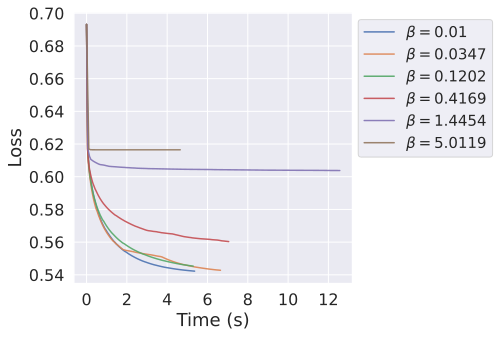

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\beta=' + str(round(beta, 4)) + '$' for beta in betas]
for history in history_GD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['func'],
                     ci=False, label=False, alpha=0.9)
plt.legend(labels, 
           bbox_to_anchor=(1.53, 1),
           fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./experiment1/beta/gd_loss_time.pdf',
            bbox_inches='tight')


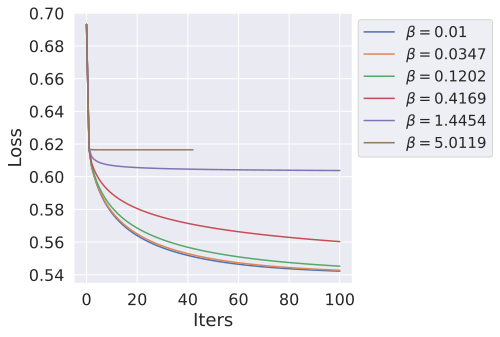

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Iters', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\beta=' + str(round(beta, 4)) + '$' for beta in betas]
for history in history_GD:
    g = sns.lineplot(palette='muted', x=range(len(history['func'])),
                     y=history['func'],
                     ci=False, label=False)
plt.legend(labels,
           bbox_to_anchor=(1.53, 1),
           fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./experiment1/beta/gd_loss__iters.pdf',
            bbox_inches='tight')

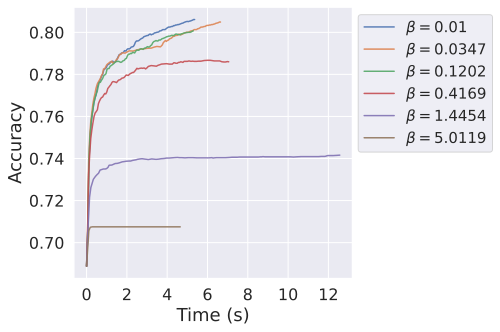

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\beta=' + str(round(beta, 4)) + '$' for beta in betas]
for history in history_GD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['acc'],
                     ci=False, label=False, alpha=0.9)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./experiment1/beta/gd_acc_time.pdf',
            bbox_inches='tight')

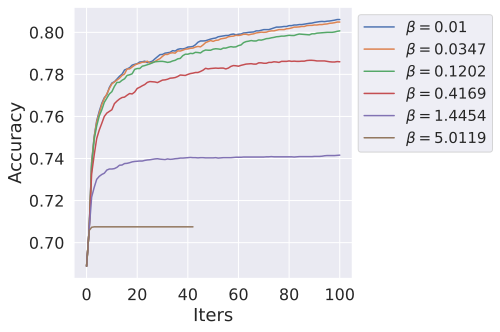

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Iters', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\beta=' + str(round(beta, 4)) + '$' for beta in betas]
for history in history_GD:
    g = sns.lineplot(palette='muted', x=range(len(history['acc'])),
                     y=history['acc'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./experiment1/beta/gd_acc_iters.pdf',
            bbox_inches='tight')

In [ ]:
beta = best_beta
alpha = best_alpha
history_GD = []
w_0 = []
w_0.append(np.zeros(X_train.shape[1]))
w_0.append(np.ones(X_train.shape[1]))
mu, sigma = 0, 1 # mean and standard deviation
rdg = np.random.default_rng(10)
w_0.append(rdg.normal(mu, sigma, X_train.shape[1]))
w_0.append(rdg.uniform(0, 1, X_train.shape[1]))
max = -1

best_w_0 = w_0[0]
for i in tqdm(range(len(w_0))):
    classifier_GD = GDClassifier(
        loss_function='binary_logistic',
        step_alpha=alpha,
        step_beta=beta,
        l2_coef=0.1,
        X_val=X_val,
        y_val=y_val)
    history_GD.append(classifier_GD.fit(X_train, 
                                        y_train, 
                                        w_0=w_0[i], 
                                        trace=True))
    acc = np.mean(classifier_GD.predict(X_val) == y_val)
    if acc > max:
        max = acc
        best_w_0 = w_0[i]
print()
print("best accuracy on validation", max)
print("best w0", best_w_0)

100%|██████████| 4/4 [00:27<00:00,  6.92s/it]


best accuracy on validation 0.8061
best w0 [0. 0. 0. ... 0. 0. 0.]


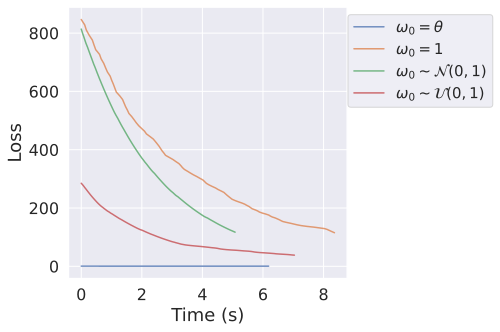

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\omega_0 = \theta$', 
          r'$\omega_0 = 1$', 
          r'$\omega_0 \sim \mathcal{N}(0, 1)$',
          r'$\omega_0 \sim \mathcal{U}(0, 1)$']
for history in history_GD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['func'],
                     ci=False, label=False, alpha=0.8)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.55, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./experiment1/w_0/gd_loss_time.pdf',
            bbox_inches='tight')

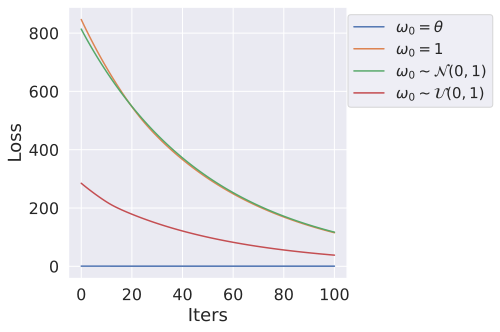

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Iters', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\omega_0 = \theta$', 
          r'$\omega_0 = 1$', 
          r'$\omega_0 \sim \mathcal{N}(0, 1)$',
          r'$\omega_0 \sim \mathcal{U}(0, 1)$']
for history in history_GD:
    g = sns.lineplot(palette='muted', x=range(len(history['func'])),
                     y=history['func'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.55, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./experiment1/w_0/gd_loss_iters.pdf',
            bbox_inches='tight')

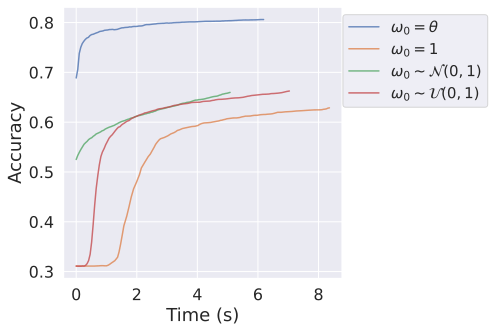

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\omega_0 = \theta$', 
          r'$\omega_0 = 1$', 
          r'$\omega_0 \sim \mathcal{N}(0, 1)$',
          r'$\omega_0 \sim \mathcal{U}(0, 1)$']
for history in history_GD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['acc'],
                     ci=False, label=False, alpha=0.8)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.55, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./experiment1/w_0/gd_acc_time.pdf',
            bbox_inches='tight')

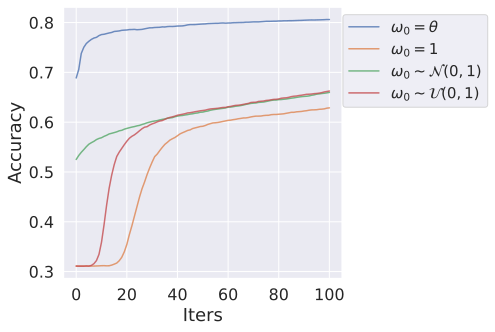

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Iters', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\omega_0 = \theta$', 
          r'$\omega_0 = 1$', 
          r'$\omega_0 \sim \mathcal{N}(0, 1)$',
          r'$\omega_0 \sim \mathcal{U}(0, 1)$']
for history in history_GD:
    g = sns.lineplot(palette='muted', 
                     x=range(len(history['acc'])),
                     y=history['acc'],
                     ci=False, label=False, alpha=0.8)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.55, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./experiment1/w_0/gd_acc_iters.pdf',
            bbox_inches='tight')

Для   
α лучшее 0.1  
β лучшее 0.01  
$ω_0$ лучшее 0

### Experiment 2  
Исследуйте поведение стохастического градиентного спуска для задачи логистической регрессии в зави-
симости от следующих параметров:  
• параметр размера шага step_alpha  
• параметр размера шага step_beta  
• размер подвыборки batch_size  (10000)   
• начального приближения  

In [ ]:
alphas = np.logspace(-4 , -1, 8)
beta = 0
history_SGD = []
max = 0
best_alpha = 0
for i in tqdm(range(len(alphas))):
    classifier_SGD = SGDClassifier(
        loss_function='binary_logistic',
        step_alpha=alphas[i],
        step_beta=beta,
        l2_coef=0.1,
        X_val=X_val,
        y_val=y_val)
    history_SGD.append(classifier_SGD.fit(X_train, 
                                          y_train, 
                                          w_0=np.zeros(X_train.shape[1]), 
                                          trace=True))
    acc = np.mean(classifier_SGD.predict(X_val) == y_val)
    if acc > max:
        best_alpha = alphas[i]
        max = acc
print()
print("best acuuracy on validation", max)
print("best alpha", best_alpha)

100%|██████████| 8/8 [02:21<00:00, 17.63s/it]


best acuuracy on validation 0.8139
best alpha 0.1


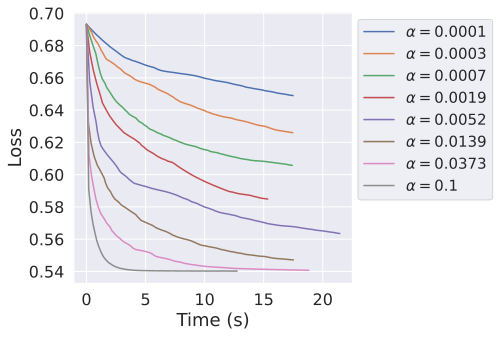

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\alpha=' + str(round(alpha, 4)) + '$' for alpha in alphas]
for history in history_SGD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['func'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./experiment2/alpha/sgd_loss_time.pdf',
            bbox_inches='tight')


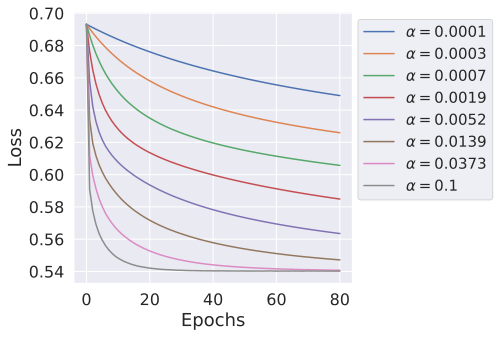

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\alpha=' + str(round(alpha, 4)) + '$' for alpha in alphas]
for history in history_SGD:
    g = sns.lineplot(palette='muted', x=range(len(history['func'])),
                     y=history['func'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./experiment2/alpha/sgd_loss__iters.pdf',
            bbox_inches='tight')

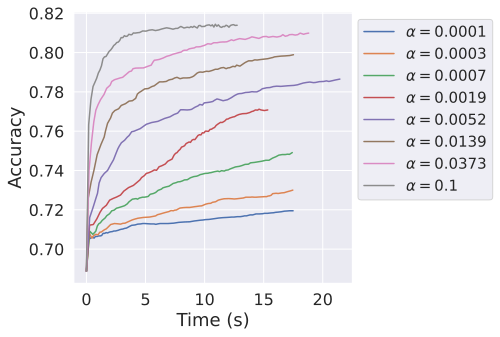

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\alpha=' + str(round(alpha, 4)) + '$' for alpha in alphas]
for history in history_SGD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['acc'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./experiment2/alpha/sgd_acc_time.pdf',
            bbox_inches='tight')


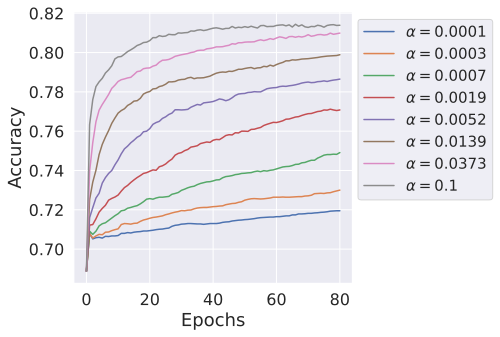

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\alpha=' + str(round(alpha, 4)) + '$' for alpha in alphas]
for history in history_SGD:
    g = sns.lineplot(palette='muted', 
                     x=range(len(history['acc'])), 
                             y=history['acc'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./experiment2/alpha/sgd_acc_iters.pdf',
            bbox_inches='tight')

In [ ]:
alphas = np.logspace(0 , 1, 5)
beta = 0
w_0 = np.zeros(X_train.shape[1])
history_SGD = []
for i in tqdm(range(len(alphas))):
    classifier_SGD = SGDClassifier(
        loss_function='binary_logistic',
        step_alpha=alphas[i],
        step_beta=beta,
        l2_coef=0.1,
        X_val=X_val,
        y_val=y_val)
    history_SGD.append(classifier_SGD.fit(X_train, 
                                        y_train, 
                                        w_0=np.zeros(X_train.shape[1]), 
                                        trace=True))

100%|██████████| 5/5 [01:05<00:00, 13.03s/it]


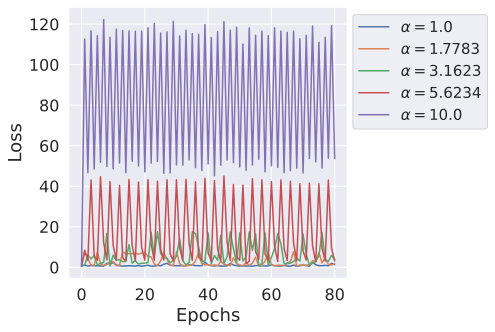

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\alpha=' + str(round(alpha, 4)) + '$' for alpha in alphas]
for history in history_SGD:
    g = sns.lineplot(palette='muted', x=range(len(history['func'])),
                     y=history['func'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('./experiment2/alpha/sgd_loss__iters_big_alphas.pdf',
            bbox_inches='tight')

In [ ]:
betas = np.logspace(-2, 0.7, 6)
alpha = best_alpha
history_SGD = []
best_beta = 0
max = 0
for i in tqdm(range(len(betas))):
    classifier_SGD = SGDClassifier(
        loss_function='binary_logistic',
        step_alpha=alpha,
        step_beta=betas[i],
        l2_coef=0.1,
        X_val=X_val,
        y_val=y_val)
    history_SGD.append(classifier_SGD.fit(X_train, 
                                        y_train, 
                                        w_0=np.zeros(X_train.shape[1]), 
                                        trace=True))
    acc = np.mean(classifier_SGD.predict(X_val) == y_val)
    if max < acc:
        max = acc
        best_beta = betas[i]
        print()
        print(acc)
        
print()
print("best acc on validation", max)
print("best beta on validation", best_beta)

 17%|█▋        | 1/6 [00:16<01:20, 16.06s/it]


0.814


 33%|███▎      | 2/6 [00:26<00:51, 12.93s/it]


0.8141


100%|██████████| 6/6 [01:10<00:00, 11.77s/it]


best acc on validation 0.8141
best beta on validation 0.034673685045253165


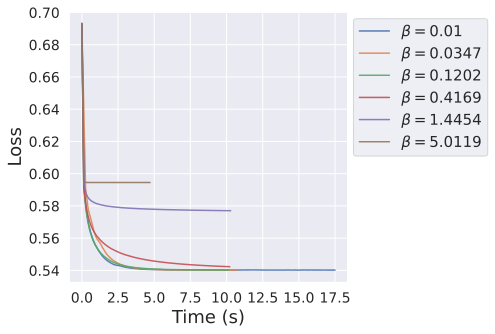

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\beta=' + str(round(beta, 4)) + '$' for beta in betas]
for history in history_SGD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['func'],
                     ci=False, label=False, alpha=0.9)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('./experiment2/beta/sgd_loss_time.pdf',
            bbox_inches='tight')


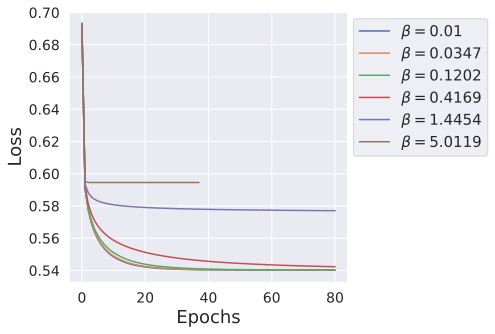

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = [r'$\beta=' + str(round(beta, 4)) + '$' for beta in betas]
for history in history_SGD:
    g = sns.lineplot(palette='muted', x=range(len(history['func'])),
                     y=history['func'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('./experiment2/beta/sgd_loss__iters.pdf',
            bbox_inches='tight')

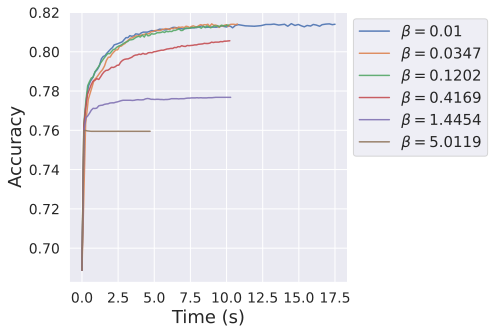

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\beta=' + str(round(beta, 4)) + '$' for beta in betas]
for history in history_SGD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['acc'],
                     ci=False, label=False, alpha=0.9)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./experiment2/beta/sgd_acc_time.pdf',
            bbox_inches='tight')

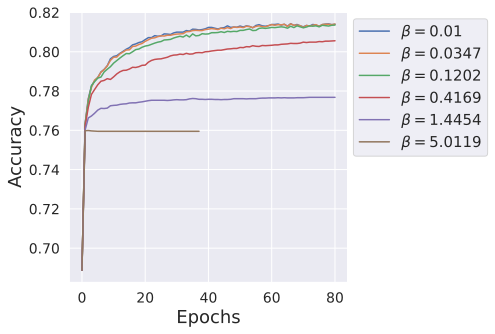

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\beta=' + str(round(beta, 4)) + '$' for beta in betas]
for history in history_SGD:
    g = sns.lineplot(palette='muted', x=range(len(history['acc'])),
                     y=history['acc'],
                     ci=False, label=False)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.53, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('./experiment2/beta/sgd_acc_iters.pdf',
            bbox_inches='tight')

In [ ]:
beta = best_beta
alpha = best_alpha
history_SGD = []
w_0 = []
w_0.append(np.zeros(X_train.shape[1]))
w_0.append(np.ones(X_train.shape[1]))
mu, sigma = 0, 1 # mean and standard deviation
rdg = np.random.default_rng(10)
w_0.append(rdg.normal(mu, sigma, X_train.shape[1]))
w_0.append(rdg.uniform(0, 1, X_train.shape[1]))
max = 0
best_w_0 = None
for i in tqdm(range(len(w_0))):
    classifier_SGD = SGDClassifier(
        loss_function='binary_logistic',
        step_alpha=alpha,
        step_beta=beta,
        l2_coef=0.1,
        X_val=X_val,
        y_val=y_val)
    history_SGD.append(classifier_SGD.fit(X_train, 
                                        y_train, 
                                        w_0=w_0[i], 
                                        trace=True))
    acc = np.mean(classifier_SGD.predict(X_val) == y_val)

    if acc > max:
        max = acc
        best_w_0 = w_0[i]
print("best acc on validation", max)
print("best w_0", best_w_0)

100%|██████████| 4/4 [00:59<00:00, 14.92s/it]

best acc on validation 0.8141
best w_0 [0. 0. 0. ... 0. 0. 0.]


TypeError: ignored

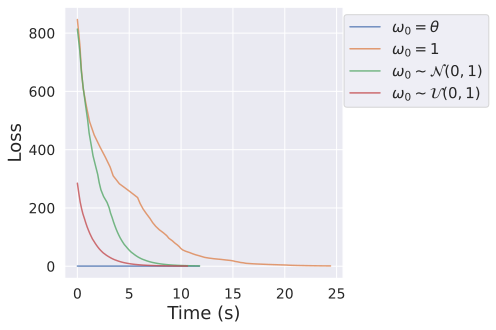

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Loss', fontsize=18)
#plt.yscale('symlog')
labels = [r'$\omega_0 = \theta$', 
          r'$\omega_0 = 1$', 
          r'$\omega_0 \sim \mathcal{N}(0, 1)$',
          r'$\omega_0 \sim \mathcal{U}(0, 1)$']
for history in history_SGD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['func'],
                     ci=False, label=False, alpha=0.8)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.55, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./experiment2/w_0/sgd_loss_time.pdf',
            bbox_inches='tight')

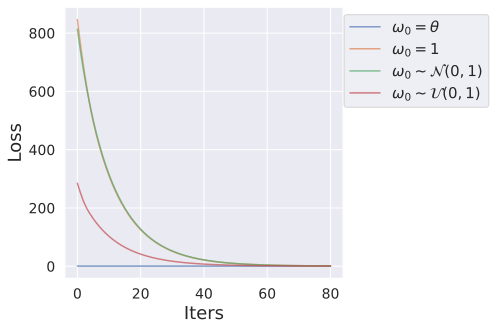

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Iters', fontsize=18)
plt.ylabel('Loss', fontsize=18)

labels = [r'$\omega_0 = \theta$', 
          r'$\omega_0 = 1$', 
          r'$\omega_0 \sim \mathcal{N}(0, 1)$',
          r'$\omega_0 \sim \mathcal{U}(0, 1)$']
for history in history_SGD:
    g = sns.lineplot(palette='muted', x=range(len(history['func'])),
                     y=history['func'],
                     ci=False, label=False, alpha=0.7)
plt.legend(labels,
           fontsize=15, 
           bbox_to_anchor=(1.55, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('./experiment2/w_0/sgd_loss_iters.pdf',
            bbox_inches='tight')

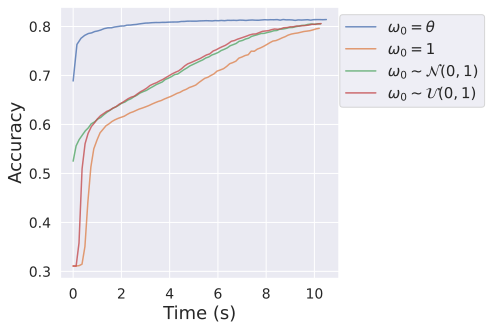

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\omega_0 = \theta$', 
          r'$\omega_0 = 1$', 
          r'$\omega_0 \sim \mathcal{N}(0, 1)$',
          r'$\omega_0 \sim \mathcal{U}(0, 1)$']
for history in history_SGD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['acc'],
                     ci=False, label=False, alpha=0.8)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.55, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./experiment2/w_0/sgd_acc_time.pdf',
            bbox_inches='tight')

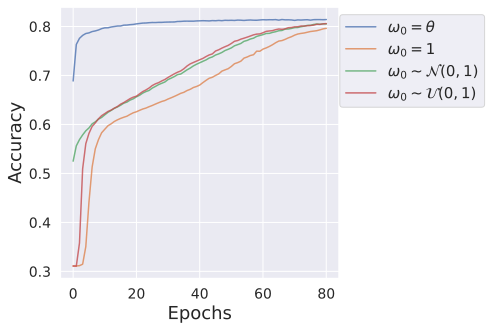

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = [r'$\omega_0 = \theta$', 
          r'$\omega_0 = 1$', 
          r'$\omega_0 \sim \mathcal{N}(0, 1)$',
          r'$\omega_0 \sim \mathcal{U}(0, 1)$']
for history in history_SGD:
    g = sns.lineplot(palette='muted', 
                     x=range(len(history['acc'])),
                     y=history['acc'],
                     ci=False, label=False, alpha=0.8)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.55, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('./experiment2/w_0/sgd_acc_iters.pdf',
            bbox_inches='tight')

In [ ]:
alpha = best_alpha
beta = best_beta
history_SGD = []
batch_sizes = [1000, 2500, 5000, 10000, 25000]
best_batch_size = 1
max = 0
for i in tqdm(range(len(batch_sizes))):
    classifier_SGD = SGDClassifier(
        batch_size=batch_sizes[i],
        step_alpha=alpha,
        step_beta=beta,
        l2_coef=0.1,
        X_val=X_val,
        y_val=y_val)
    history_SGD.append(classifier_SGD.fit(X_train, 
                                          y_train, 
                                          w_0=np.zeros(X_train.shape[1]), 
                                          trace=True, 
                                          log_freq=1))
    acc = np.mean(classifier_SGD.predict(X_val) == y_val)
    print()
    print(f'batch {batch_sizes[i]}')
    print(f'acc {acc}')
    if acc > max:
        best_batch_size = batch_sizes[i]
        max = acc

print("best acc on validation", max)
print("best_batch_size", best_batch_size)

 20%|██        | 1/5 [01:00<04:02, 60.67s/it]


batch 1000
acc 0.8145


 40%|████      | 2/5 [01:26<01:59, 39.99s/it]


batch 2500
acc 0.814


 60%|██████    | 3/5 [01:42<00:58, 29.28s/it]


batch 5000
acc 0.8134


 80%|████████  | 4/5 [01:53<00:22, 22.15s/it]


batch 10000
acc 0.8141


100%|██████████| 5/5 [01:58<00:00, 23.76s/it]


batch 25000
acc 0.8043
best acc on validation 0.8145
best_batch_size 1000


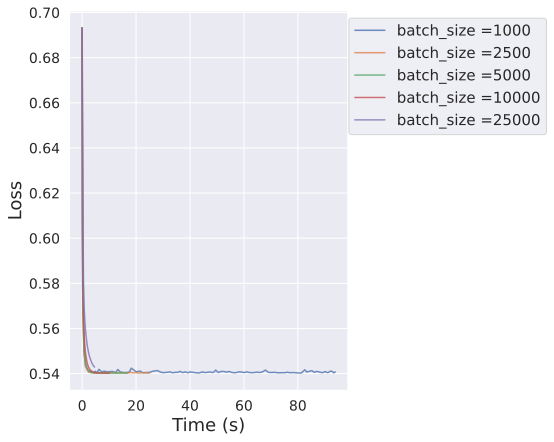

In [ ]:
plt.figure(figsize=(5, 7))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = ['batch_size =' + str(size) for size in batch_sizes]
for history in history_SGD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['func'],
                     ci=False, label=False, alpha=0.8)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.74, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('./experiment2/batch_size/sgd_loss_time.pdf',
            bbox_inches='tight')

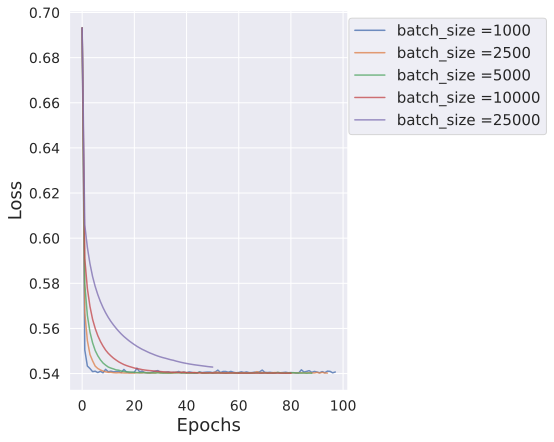

In [ ]:
plt.figure(figsize=(5, 7))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
labels = ['batch_size =' + str(size) for size in batch_sizes]
for history in history_SGD:
    g = sns.lineplot(palette='muted', 
                     x=range(len(history['func'])),
                     y=history['func'],
                     ci=False, label=False, alpha=0.8)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.74, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('./experiment2/batch_size/sgd_loss_iters.pdf',
            bbox_inches='tight')

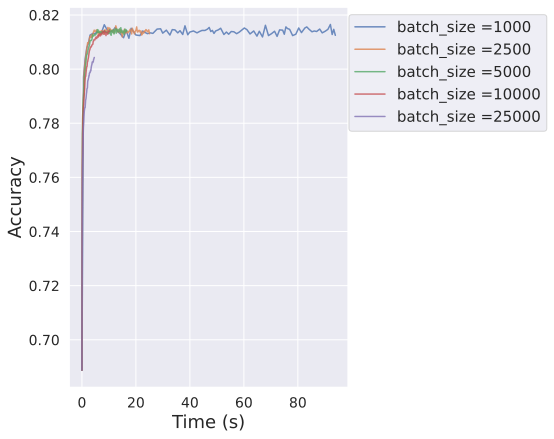

In [ ]:
plt.figure(figsize=(5, 7))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = ['batch_size =' + str(size) for size in batch_sizes]
for history in history_SGD:
    real_time = np.cumsum(history['time'])
    g = sns.lineplot(palette='muted', x=real_time, y=history['acc'],
                     ci=False, label=False, alpha=0.8)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.74, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('./experiment2/batch_size/sgd_acc_time.pdf',
            bbox_inches='tight')

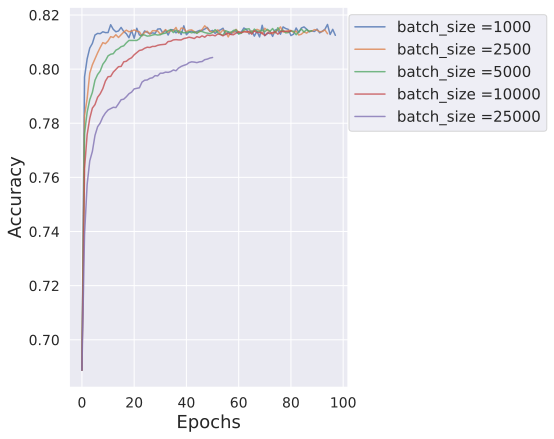

In [ ]:
plt.figure(figsize=(5, 7))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
labels = ['batch_size =' + str(size) for size in batch_sizes]
for history in history_SGD:
    g = sns.lineplot(palette='muted', 
                     x=range(len(history['acc'])),
                     y=history['acc'],
                     ci=False, label=False, alpha=0.8)
plt.legend(labels,
           fontsize=15,
           bbox_to_anchor=(1.74,1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./experiment2/batch_size/sgd_acc_iters.pdf',
            bbox_inches='tight')

Далее будем использовать batch_size = 5000, засчеь которого аллгоритм будет работать приемлемое время и давать хорошую сходимость к минимуму при заданном числе итераций


### Experiment 3  
Сравните поведение двух методов между собой, сделайте выводы.  
Пусть:  
⋅ α = 0.1  
⋅ β = 0.01 (для GD)
⋅ β = 0.0347 (для SGD)
⋅ batch_size = 5000  
⋅ $\omega_{0}$ = (0,$\ldots$,0) 


In [ ]:
clf_GD = GDClassifier(
    step_alpha=0.1,
    step_beta=0.01,
    l2_coef=0.1,
    X_val=X_val,
    y_val=y_val
)
history_GD = clf_GD.fit(X_train, 
                        y_train, 
                        w_0=np.zeros(X_train.shape[1]), 
                        trace=True)

clf_SGD = SGDClassifier(
    step_alpha=0.1,
    step_beta=0.0347,
    l2_coef=0.1,
    batch_size=10000,
    X_val=X_val,
    y_val=y_val
)
history_SGD = clf_SGD.fit(X_train, 
                          y_train, 
                          w_0=np.zeros(X_train.shape[1]), 
                          trace=True)

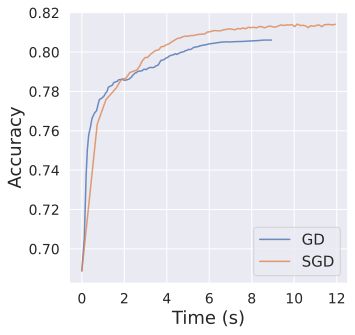

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)

real_time = np.cumsum(history_GD['time'])
g = sns.lineplot(palette='muted', x=real_time, y=history_GD['acc'],
                ci=False, label=False, alpha=0.8)

real_time = np.cumsum(history_SGD['time'])
g = sns.lineplot(palette='muted', x=real_time, y=history_SGD['acc'],
                ci=False, label=False, alpha=0.8)

plt.legend(['GD', 'SGD'],
           fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./experiment3/acc_time.pdf',
            bbox_inches='tight')

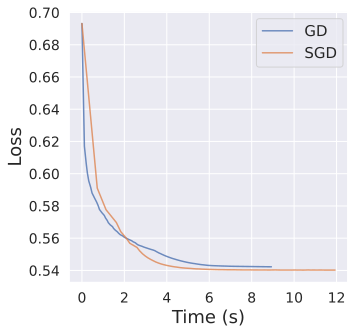

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Loss', fontsize=18)

real_time = np.cumsum(history_GD['time'])
g = sns.lineplot(palette='muted', x=real_time, y=history_GD['func'],
                ci=False, label=False, alpha=0.8)

real_time = np.cumsum(history_SGD['time'])
g = sns.lineplot(palette='muted', x=real_time, y=history_SGD['func'],
                ci=False, label=False, alpha=0.8)

plt.legend(['GD', 'SGD'],
           fontsize=15,
           bbox_to_anchor=(1.01, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./experiment3/loss_time.pdf',
            bbox_inches='tight')

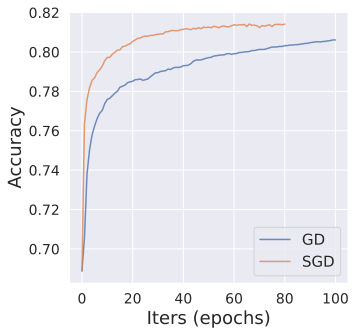

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Iters (epochs)', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)

g = sns.lineplot(palette='muted', 
                 x=range(len(history_GD['acc'])),
                 y=history_GD['acc'],
                 ci=False, label=False, alpha=0.8)

g = sns.lineplot(palette='muted', 
                 x=range(len(history_SGD['acc'])),
                 y=history_SGD['acc'],
                 ci=False, label=False, alpha=0.8)
plt.legend(["GD", "SGD"],
           fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./experiment3/acc_iters.pdf',
            bbox_inches='tight')

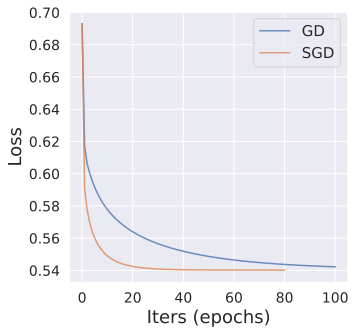

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Iters (epochs)', fontsize=18)
plt.ylabel('Loss', fontsize=18)

g = sns.lineplot(palette='muted', 
                 x=range(len(history_GD['func'])),
                 y=history_GD['func'],
                 ci=False, label=False, alpha=0.8)

g = sns.lineplot(palette='muted', 
                 x=range(len(history_SGD['func'])),
                 y=history_SGD['func'],
                 ci=False, label=False, alpha=0.8)
plt.legend(["GD", "SGD"],
           fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./experiment3/acc_iters.pdf',
            bbox_inches='tight')

In [ ]:
print("GD accuracy %f"%(np.mean(clf_GD.predict(X_val) == y_val)))
print("GD time %f"%(np.sum(history_GD['time'])))
print("GD loss function %f"%(history_GD['func'][-1]))

print("SGD accuracy %f"%(np.mean(clf_SGD.predict(X_val) == y_val)))
print("SGD time %f"%(np.sum(history_SGD['time'])))
print("SGD loss function %f"%(history_SGD['func'][-1]))

GD accuracy 0.806100
GD time 8.925143
GD loss function 0.542243
SGD accuracy 0.814100
SGD time 11.928005
SGD loss function 0.540191


### Experiment 4  
Примените алгоритм лемматизации (например, WordNetLemmatizer из библотеки nltk) к коллекции. Удалите из текста стоп-слова (например, используя список стоп-слов из nltk). Исследуйте, как предобработка
корпуса повлияла на точность классификации, время работы алгоритма и размерность признакового про-
странства.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger') 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.ADJ, 'V': wordnet.VERB,
        'N': wordnet.NOUN, 'R': wordnet.ADV
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.NOUN
    
def simple_lemmatizer(sentence):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = word_tokenize(sentence, language='english')
    pos_taged = [
        (word, get_wordnet_pos(tag))
        for word, tag in nltk.pos_tag(tokenized_sent)
    ]
    return " ".join([
        lemmatizer.lemmatize(word, tag)
        for word, tag in pos_taged
    ])

In [ ]:
lematized_sent_train = [simple_lemmatizer(sent) for sent in data_train['comment_text'][idx_[:train_size]]]

In [ ]:
lematized_sent_val = [simple_lemmatizer(sent) for sent in data_train['comment_text'][idx_[train_size:]]]

In [ ]:
word_tokenize("write wrote", language='english')

['write', 'wrote']

In [ ]:
vectoriser = CountVectorizer(min_df=0.0001)
X_train_mod = vectoriser.fit_transform(lematized_sent_train)
vectoriser.fit(lematized_sent_train)
X_val_mod = vectoriser.transform(lematized_sent_val)

In [ ]:
print("Size of modified X_train", X_train_mod.shape)
print("Size of not modified X_train", X_train.shape)

Size of modified X_train (42061, 13094)
Size of not modified X_train (42061, 16050)


In [ ]:
stop_words = set(stopwords.words('english'))
mod_sent_train = []
mod_sent_val = []
for sent in lematized_sent_train:
    mod_sent = ' '.join([tok for tok in word_tokenize(sent) if tok not in stop_words])
    mod_sent_train .append(mod_sent)
for sent in lematized_sent_val:
    mod_sent = ' '.join([tok for tok in word_tokenize(sent) if tok not in stop_words])
    mod_sent_val.append(mod_sent)

In [ ]:
vectoriser = CountVectorizer(min_df=0.0001)
X_train_mod = vectoriser.fit_transform(mod_sent_train)
vectoriser.fit(mod_sent_train)
X_val_mod = vectoriser.transform(mod_sent_val)

In [ ]:
print("Size of modified X_train", X_train_mod.shape)
print("Size of not modified X_train", X_train.shape)
print("Size of modified X_val", X_val_mod.shape)
print("Size of not modified X_val", X_val.shape)

Size of modified X_train (42061, 12964)
Size of not modified X_train (42061, 16050)
Size of modified X_val (10000, 12964)
Size of not modified X_val (10000, 16050)


In [ ]:
clf_GD = GDClassifier(
    step_alpha=0.1,
    step_beta=0.01,
    l2_coef=0.1
)
history_GD = clf_GD.fit(X_train_mod, 
                        y_train, 
                        w_0=np.zeros(X_train_mod.shape[1]), 
                        trace=True)

clf_SGD = SGDClassifier(
    step_alpha=0.1,
    step_beta=0.0347,
    l2_coef=0.1,
    batch_size=10000
)
history_SGD = clf_SGD.fit(X_train_mod, 
                          y_train, 
                          w_0=np.zeros(X_train_mod.shape[1]), 
                          trace=True)

In [ ]:
print("GD accuracy %f"%(np.mean(clf_GD.predict(X_val_mod) == y_val)))
print("GD time %f"%(np.sum(history_GD['time'])))

print("SGD accuracy %f"%(np.mean(clf_SGD.predict(X_val_mod) == y_val)))
print("SGD time %f"%(np.sum(history_SGD['time'])))

GD accuracy 0.820700
GD time 5.081007
SGD accuracy 0.830700
SGD time 10.939810


In [ ]:
acc1 = 0.814100 
acc2 = 0.830700
(1 - (1 - acc2) / (1 - acc1)) * 100

8.929532006455055

# Old version
GD accuracy 0.806100  
GD time 8.925143  
SGD accuracy 0.814100  
SGD time 11.928005  
Amount of features 16050 


#New version  
GD accuracy 0.820700  
GD time 5.081007  
SGD accuracy 0.830700  
SGD time 10.939810  
Amount of features 12964


### Experiment 5  
Исследуйте качество, время работы алгоритма и размер признакового пространства в зависимости от
следуюших факторов:
• использовалось представление BagOfWords или Tfidf.  
• параметров min_df и max_df конструкторов.  
#### Замечание.   
Для построения tf-idf представления воспользуйтесь TfidfTransformer или TfidfVectorizer
из библиотеки sklearn.


In [ ]:
vectorizer_tfid = TfidfVectorizer(min_df=0.0001)
X_train_tfid = vectorizer_tfid.fit_transform(data_train['comment_text'])[idx_[:train_size]]
X_val_tfid = vectorizer_tfid.fit_transform(data_train['comment_text'])[idx_[train_size:]]

vectorizer_bow = CountVectorizer(min_df=0.0001)
X_train_bow = vectorizer_bow.fit_transform(data_train['comment_text'])[idx_[:train_size]]
X_val_bow = vectorizer_bow.fit_transform(data_train['comment_text'])[idx_[train_size:]]


In [ ]:
print("X_train_tfid", X_train_tfid.shape)
print("X_val_tfid", X_val_tfid.shape)
print("X_train_bow", X_train_bow.shape)
print("X_val_bow", X_val_bow.shape)

X_train_tfid (42061, 16050)
X_val_tfid (10000, 16050)
X_train_bow (42061, 16050)
X_val_bow (10000, 16050)


In [ ]:
clf_GD = GDClassifier(
    step_alpha=0.1,
    step_beta=0.01,
    l2_coef=0.1
)
history_GD_bow = clf_GD.fit(X_train_bow, 
                            y_train, 
                            w_0=np.zeros(X_train_bow.shape[1]), 
                            trace=True)

acc_GD_bow = np.mean(clf_GD.predict(X_val_bow) == y_val)

history_GD_tfid = clf_GD.fit(X_train_tfid, 
                             y_train, 
                             w_0=np.zeros(X_train_tfid.shape[1]), 
                             trace=True)

acc_GD_tfid = np.mean(clf_GD.predict(X_val_tfid) == y_val)

clf_SGD = SGDClassifier(
    step_alpha=0.1,
    step_beta=0.0347,
    l2_coef=0.1,
    batch_size=10000
)
history_SGD_bow = clf_SGD.fit(X_train_bow, 
                              y_train, 
                              w_0=np.zeros(X_train_bow.shape[1]), 
                              trace=True)

acc_SGD_bow = np.mean(clf_SGD.predict(X_val_bow) == y_val)

history_SGD_tfid = clf_SGD.fit(X_train_tfid, 
                              y_train, 
                              w_0=np.zeros(X_train_tfid.shape[1]), 
                              trace=True)
acc_SGD_tfid = np.mean(clf_SGD.predict(X_val_tfid) == y_val)


In [ ]:
for sent in data_train["comment_text"][idx_[train_size:][clf_SGD.predict(X_val_tfid) != y_val]].sample(5):
    print(sent)

fuck you  are you happy that jews like madoff bankrupted your country   actually it is not a real country  just a 800lb pitbull for israel   fuck you  you stupid american   go fight and die in a war for the jews   how many american jews are serving in iraq and afghanistan  oh ya zero  they let you stupid goys die for them   fuck you  you retard    go eat a bowl of jewish lies  you stupid fuck  your life is poitnless 
leave my damn user page   talk page alone stop making changes to my user page and talk page    what is your problem  seriously  p s  stop stalking me by reverting all of my work and just because you re some loser who has to follow me around undoing all my work to try and get back at me some how for some reason i don t know of 
psycho     why do you keep telling us that our page is being vandalized       it is our page  can we do what we want  nobody likes you  you are such a dickhead  you lesbian butch     colleen vanessa     
what a ridiculous suggestion  if you don t thi

In [ ]:
print("GD accuracy tfid %f"%(acc_GD_tfid))
print("GD time tfid %f"%(np.sum(history_GD_tfid['time'])))
print("GD accuracy BOW %f"%(acc_GD_bow))
print("GD time BOW %f"%(np.sum(history_GD_bow['time'])))
print()
print("SGD accuracy tfid %f"%(acc_SGD_tfid))
print("SGD time tfid %f"%(np.sum(history_SGD_tfid['time'])))
print("SGD accuracy BOW %f"%(acc_SGD_bow))
print("SGD time BOW %f"%(np.sum(history_SGD_bow['time'])))

GD accuracy tfid 0.721500
GD time tfid 6.127796
GD accuracy BOW 0.806100
GD time BOW 7.759336

SGD accuracy tfid 0.723900
SGD time tfid 8.624678
SGD accuracy BOW 0.814100
SGD time BOW 11.931548


In [ ]:
data_train

,Unnamed: 0,comment_text,is_toxic
0,0,explanation why the edits made under my userna...,False
1,1,d aww he matches this background colour i m s...,False
2,2,hey man i m really not trying to edit war it...,False
3,3,more i can t make any real suggestions on im...,False
4,4,you sir are my hero any chance you remember...,False
...,...,...,...
52056,159494,our previous conversation you fucking sh...,True
52057,159514,you are a mischievious pubic hair,True
52058,159541,your absurd edits your absurd edits on great...,True
52059,159546,hey listen don t you ever delete my edi...,True


In [ ]:
min_df_list = [0.00001, 0.0001, 0.01, 0.1, 0.3]
max_df_list = [0.01, 0.1, 0.25, 0.4, 0.5, 1]
history_GD = []
acc_GD = []
history_SGD = []
acc_SGD = []
shape_GD = []
shape_SGD = []
clf_GD = GDClassifier(
        step_alpha=0.1,
        step_beta=0.01,
        l2_coef=0.1
    )
clf_SGD = SGDClassifier(
        step_alpha=0.1,
        step_beta=0.0347,
        l2_coef=0.1,
        batch_size=10000
    )
for min_df in tqdm(min_df_list):
    
    vectorizer = CountVectorizer(min_df=min_df)
    X_train_ = vectorizer.fit_transform(data_train['comment_text'])[idx_[:train_size]]
    X_val_ = vectorizer.fit_transform(data_train['comment_text'])[idx_[train_size:]]

    history_GD.append(clf_GD.fit(X_train_, 
                                 y_train, 
                                 w_0=np.zeros(X_train_.shape[1]), 
                                 trace=True))
    acc_GD.append(np.mean(clf_GD.predict(X_val_) == y_val))
    shape_GD.append(X_train_.shape[1])

    history_SGD.append(clf_SGD.fit(X_train_,
                                   y_train, 
                                   w_0=np.zeros(X_train_.shape[1]), 
                                   trace=True))
    acc_SGD.append(np.mean(clf_SGD.predict(X_val_) == y_val))
    shape_SGD.append(X_train_.shape[1])


100%|██████████| 5/5 [01:26<00:00, 17.35s/it]


In [ ]:
time_GD = [np.sum(history['time']) for history in history_GD]
time_SGD = [np.sum(history['time']) for history in history_SGD]
print("acc_SGD", acc_SGD)
print("acc_GD", acc_GD)
print("shape_GD", shape_GD)
print("shape_SGD", shape_SGD)
print("time_GD", time_GD)
print("time_SGD", time_SGD)

acc_SGD [0.8137, 0.8141, 0.8056, 0.7636, 0.7244]
acc_GD [0.8063, 0.8061, 0.8, 0.7603, 0.7253]
shape_GD [89368, 16050, 568, 55, 11]
shape_SGD [89368, 16050, 568, 55, 11]
time_GD [8.248152732849121, 5.406422138214111, 2.758293867111206, 1.8334412574768066, 1.2578606605529785]
time_SGD [15.00288438796997, 10.770638227462769, 5.923479795455933, 4.012347936630249, 2.9513652324676514]


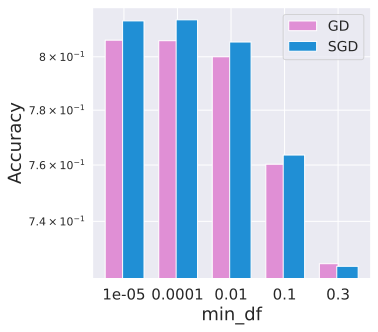

In [ ]:
columns = np.arange(1, 6, 1)
index = np.arange(len(columns))
plt.figure(figsize = (5, 5))
plt.yscale('log')
plt.xticks(index + 0.2, columns)
plt.grid(True, which='both')
#plt.title("Зависимость оценки качества, полученной с \nпомощью кросс-валидации,"
#  "от количества соседей", fontsize=16)
plt.ylabel("Accuracy", fontsize=18)
plt.xlabel("min_df", fontsize=18)
plt.bar(index, acc_GD, width = 0.35,
        label='GD', color='#e08fd5')
plt.bar(index + 0.35, acc_SGD,
        label='SGD', width = 0.4, color='#208fd5')
plt.xticks(index + 0.175, min_df_list, fontsize=15)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.savefig('./experiment5/mindf_acc.pdf', bbox_inches='tight')

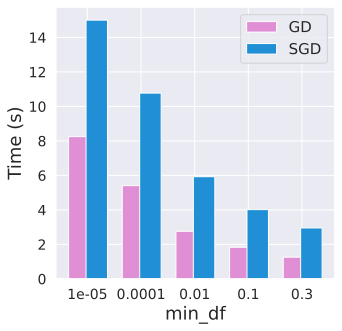

In [ ]:
columns = np.arange(1, 6, 1)
index = np.arange(len(columns))
plt.figure(figsize = (5, 5))
#plt.yscale('log')
plt.xticks(index + 0.2, columns)
plt.grid(True, which='both')
#plt.title("Зависимость оценки качества, полученной с \nпомощью кросс-валидации,"
#  "от количества соседей", fontsize=16)
plt.ylabel("Time (s)", fontsize=18)
plt.xlabel("min_df", fontsize=18)
plt.bar(index, time_GD, width = 0.35,
        label='GD', color='#e08fd5')
plt.bar(index + 0.35, time_SGD,
        label='SGD', width = 0.4, color='#208fd5')
plt.xticks(index + 0.175, min_df_list, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=15)
plt.savefig('./experiment5/mindf_time.pdf', bbox_inches='tight')

In [ ]:
max_df_list = [0.1, 0.25, 0.35, 0.45, 0.55, 0.7]
history_GD = []
acc_GD = []
history_SGD = []
acc_SGD = []
shape_GD = []
shape_SGD = []
clf_GD = GDClassifier(
        step_alpha=0.1,
        step_beta=0.01,
        l2_coef=0.1
    )
clf_SGD = SGDClassifier(
        step_alpha=0.1,
        step_beta=0.0347,
        l2_coef=0.1,
        batch_size=10000
    )
for max_df in tqdm(max_df_list):
    
    vectorizer = CountVectorizer(min_df=0.0001, max_df=max_df)
    X_train_ = vectorizer.fit_transform(data_train['comment_text'])[idx_[:train_size]]
    X_val_ = vectorizer.fit_transform(data_train['comment_text'])[idx_[train_size:]]

    history_GD.append(clf_GD.fit(X_train_, 
                                 y_train, 
                                 w_0=np.zeros(X_train_.shape[1]), 
                                 trace=True))
    acc_GD.append(np.mean(clf_GD.predict(X_val_) == y_val))
    shape_GD.append(X_train_.shape[1])

    history_SGD.append(clf_SGD.fit(X_train_,
                                   y_train, 
                                   w_0=np.zeros(X_train_.shape[1]), 
                                   trace=True))
    acc_SGD.append(np.mean(clf_SGD.predict(X_val_) == y_val))
    shape_SGD.append(X_train_.shape[1])


100%|██████████| 6/6 [02:07<00:00, 21.26s/it]


In [ ]:
time_GD = [np.sum(history['time']) for history in history_GD]
time_SGD = [np.sum(history['time']) for history in history_SGD]
print("acc_SGD", acc_SGD)
print("acc_GD", acc_GD)
print("shape_GD", shape_GD)
print("shape_SGD", shape_SGD)
print("time_GD", time_GD)
print("time_SGD", time_SGD)

acc_SGD [0.8294, 0.8218, 0.8212, 0.817, 0.8162, 0.8141]
acc_GD [0.8164, 0.8123, 0.8109, 0.8099, 0.8086, 0.8061]
shape_GD [15995, 16034, 16041, 16046, 16048, 16050]
shape_SGD [15995, 16034, 16041, 16046, 16048, 16050]
time_GD [4.157719135284424, 5.116368770599365, 5.102946519851685, 7.849824905395508, 5.250086545944214, 7.435912847518921]
time_SGD [8.469584465026855, 10.102173328399658, 9.964703798294067, 10.780262470245361, 10.446745872497559, 11.048921346664429]


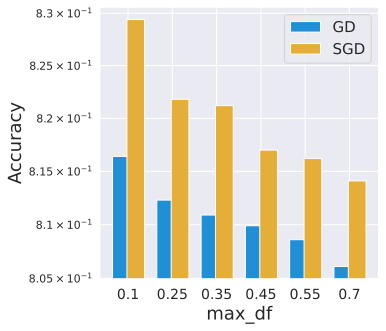

In [ ]:
columns = np.arange(1, 7, 1)
index = np.arange(len(columns))
plt.figure(figsize = (5, 5))
plt.yscale('log')
plt.xticks(index + 0.2, columns)
plt.grid(True, which='both')
#plt.title("Зависимость оценки качества, полученной с \nпомощью кросс-валидации,"
#  "от количества соседей", fontsize=16)
plt.ylabel("Accuracy", fontsize=18)
plt.xlabel("max_df", fontsize=18)
plt.bar(index, acc_GD, width = 0.35,
        label='GD', color='#208fd5')
plt.bar(index + 0.35, acc_SGD,
        label='SGD', width = 0.4, color='#e5ae38')
plt.xticks(index + 0.175, max_df_list, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=15)
#plt.legend(bbox_to_anchor=(1.01, 1))
plt.savefig('./experiment5/maxdf_acc.pdf', bbox_inches='tight')

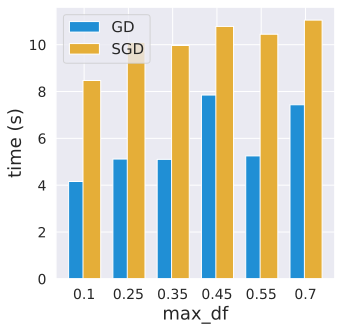

In [ ]:
columns = np.arange(1, 7, 1)
index = np.arange(len(columns))
plt.figure(figsize = (5, 5))
#plt.yscale('log')
plt.xticks(index + 0.2, columns)
plt.grid(True, which='both')
#plt.title("Зависимость оценки качества, полученной с \nпомощью кросс-валидации,"
#  "от количества соседей", fontsize=16)
plt.ylabel("Time (s)", fontsize=18)
plt.xlabel("max_df", fontsize=18)
plt.bar(index, time_GD, width = 0.35,
        label='GD', color='#208fd5')
plt.bar(index + 0.35, time_SGD,
        label='SGD', width = 0.4, color='#e5ae38')
plt.xticks(index + 0.175, max_df_list, fontsize=14)
plt.legend(fontsize=15)
plt.yticks(fontsize=14)
plt.savefig('./experiment5/maxdf_time.pdf', bbox_inches='tight')

In [ ]:
lematized_sent_train = [simple_lemmatizer(sent) for sent in tqdm(data_train['comment_text'])]
lematized_sent_test = [simple_lemmatizer(sent) for sent in tqdm(data_test['comment_text'])]
stop_words = set(stopwords.words('english'))
mod_sent_train = []
mod_sent_test = []
for sent in tqdm(lematized_sent_train):
    mod_sent = ' '.join([tok for tok in word_tokenize(sent) if tok not in stop_words])
    mod_sent_train .append(mod_sent)
for sent in tqdm(lematized_sent_test):
    mod_sent = ' '.join([tok for tok in word_tokenize(sent) if tok not in stop_words])
    mod_sent_test.append(mod_sent)

In [11]:
vectoriser = CountVectorizer(min_df=0.0001, max_df=0.1)
X_train = vectoriser.fit_transform(mod_sent_train)
y_train = 2 * np.array(data_train['is_toxic']) - 1
vectoriser.fit(mod_sent_train)
X_test = vectoriser.transform(mod_sent_test)
y_test = 2 * np.array(data_test['is_toxic']) - 1

In [12]:
clf_SGD = SGDClassifier(
        step_alpha=0.1,
        step_beta=0.0347,
        l2_coef=0.1,
        batch_size=10000,
        max_iters=1000
    )
clf_SGD.fit(X_train, 
            y_train,
            w_0=np.zeros(X_train.shape[1]),
            trace=False)

In [13]:
prediction = clf_SGD.predict(X_test)
print("acc", np.mean(prediction == y_test))

acc 0.8473592571096924


  Следующая функция фзята из интернета https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

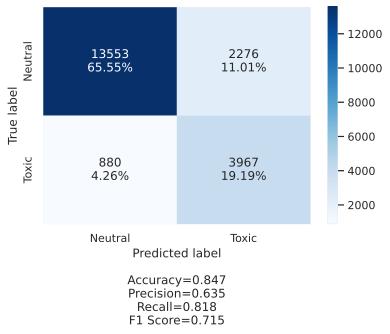

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_m = confusion_matrix(prediction, y_test)
make_confusion_matrix(conf_m, categories=['Neutral', 'Toxic'])
plt.savefig('./experiment6/conf_m.pdf', bbox_inches='tight')

In [16]:
np.sum(y_test == -1)

14433

In [70]:
print("FP")
for sent in data_test['comment_text'][(prediction != y_test) & (y_test != 1)].sample(100):
    print(sent.strip())

FP
lol       wow  how stupid  i think this would really screw us up  it s just like painkillers  except  for the earth  solving the effects  not the cause  not gonna work
you people should be criticized for justifying buchanan s racist views  it is like saying what hitler did is right
dear god this site is horrible
go screw yourself ed
no it wasn t  you re lying   just leave my talk page alone
reply  imran khan is an ethnic pashtun  he is not a punjabi  stop trying to steal other people and claim them as punjabis when they are not
about brossow     an anal retentive grammar nazi from southern minnesota
da te pitam beganovicu       zasto se uvlacis srbima znas vec gdje  umjesto da podrzis nas bosnjake sto se borimo da otvorimo bosniakophobia clanak  ukljucujuci i da zastitimo srebrenica massacre clanak  ti nas jos blatis  kako te bolan nije sramota prodana duso
the gay kid
as they turn a studiously blind eye to crap churned out in their own backyard
jeremy harmon kiehl s asspie anus is 